In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import json
import os
import time
import nltk
nltk.download('punkt')
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from bertopic import BERTopic
from bertopic.representation import BaseRepresentation
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

import google.generativeai as genai
from dotenv import load_dotenv

csv_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/MPE_dataset_translated_batched.csv'
# csv_path = '/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/MPE_dataset_translated_llama.csv'
df = pd.read_csv(csv_path)


df.dropna(subset=['phen_report_english'], inplace=True)
df = df[df.phen_report_english.str.strip() != '']

# ----------------------------------------
reports = df['phen_report_english'].tolist()
print(f"Loaded {len(reports)} (translated) documents for BERTopic modeling.")
# ----------------------------------------

# ----------------------------------------
# Divide each report into sentences
reports_sentences = [nltk.sent_tokenize(report) for report in reports]

sentences = [sentence for report in reports_sentences for sentence in report]
print(f"Total number of sentences across all reports: {len(sentences)}")
# ----------------------------------------

min_word_count = 2
sentences = [s for s in sentences if len(s.split()) > min_word_count]
print(f"Total number of sentences after filtering by length: {len(sentences)}")

docs = sentences

Loaded 830 (translated) documents for BERTopic modeling.
Total number of sentences across all reports: 6107
Total number of sentences after filtering by length: 5920


[nltk_data] Downloading package punkt to /Users/rbeaute/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Load both datasets
df_batched = pd.read_csv('/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/MPE_dataset_translated_batched.csv')
df_llama = pd.read_csv('/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/MPE_dataset_translated_llama.csv')

# Drop NA and empty reports for fair comparison
df_batched = df_batched.dropna(subset=['phen_report_english'])
df_batched = df_batched[df_batched['phen_report_english'].str.strip() != '']

df_llama = df_llama.dropna(subset=['phen_report_english'])
df_llama = df_llama[df_llama['phen_report_english'].str.strip() != '']

# Compare the first 10 reports (of the 2 translatiuons) side by side
for i in range(10):
    print(f"Report {i+1}:")
    print("Batched translation:")
    print(df_batched.iloc[i]['phen_report_english'])
    print("\nLlama translation:")
    print(df_llama.iloc[i]['phen_report_english'])
    print('-'*100)

Report 1:
Batched translation:
Pure awareness, for me, is an all-pervasive state where the boundary between myself and the surrounding reality merges, while both my body and reality remain clear. It has to do with a rhythm linked to breathing that becomes a unison between me and every form of life around me. It is muffled and sharp at the same time.

Llama translation:
"Pure awareness is for me a pervasive state where the boundary between me and the reality around me dissolves, yet my body and reality remain clear. It has to do with a rhythm tied to breathing that becomes harmonious between me and every form of life around me. It's hazy and clear at the same time."
----------------------------------------------------------------------------------------------------
Report 2:
Batched translation:
My first experience that would fit your description of "consciousness of consciousness" occurred at a very young age. Due to the death of my mother (when I was seven years old), I, as a primary 

In [21]:
for i, report in enumerate(reports[:10]):
    print(f"Report {i+1}:\n{report}\n{'-'*80}")

Report 1:
Pure awareness, for me, is an all-pervasive state where the boundary between myself and the surrounding reality merges, while both my body and reality remain clear. It has to do with a rhythm linked to breathing that becomes a unison between me and every form of life around me. It is muffled and sharp at the same time.
--------------------------------------------------------------------------------
Report 2:
My first experience that would fit your description of "consciousness of consciousness" occurred at a very young age. Due to the death of my mother (when I was seven years old), I, as a primary school student, spent long afternoons and weekends with thoughts and questions about the meaning of life. One day, the following question arose in my mind: "Who actually asked that? Who is thinking here? Who am I?" At that moment, I felt for the first time that I am not my thoughts, but the invisible thinker. I felt like a lonely spectator in an empty cinema who suddenly realized t

In [ ]:
original_sentences = [sentence for report in reports_sentences for sentence in report]
removed_sentences = [s for s in original_sentences if len(s.split()) < min_word_count]
for s in removed_sentences:
    print(s)

1.
2.
1.
2.
3.
ANONYMISATION?
All-filling.
No!
Completeness.
Being.
Afternoon.
Neutral.
No-things.
back."
1.
2.
Bodyless.
Unity.
PS.
1.
2.
1.
2.
3.
Unedited.
1.
2.
3.
Unseparated.
Good.
Now.
Just.
Being.
Compassion.
Oh!
Simplicity.
minutes?
1.
2.
3.
4.
Comfort.
Resting.
Nurtured.
1.
2.
3.
4.
1.
2.
3.
!
1.
2.
3.
4.
1.
2.
P.S.
Nothing.
Wow.
1.
2.
Untouched.
Thanks.
').
1.
2.
3.
1.
2.
3.
4.
1.
2.
Mannheim!
Astonishing.
Perfect.
One-sided.
Astonishing!
1.
2.
1.
2.
1.
2.
2.
1.
2.
...
1.
2.
3.
4.
5.
appear.
Peaceful.
1.
2.
Bliss.
Suchness.


In [23]:
from huggingface_hub import hf_hub_download  # For loading the model instance from Hugging Face
import os  # For creating system directories
from llama_cpp import Llama  # LLM Wrapper
from bertopic.representation import KeyBERTInspired, LlamaCPP  # Representation Comparison
from sentence_transformers import SentenceTransformer  # Embedding Model Wrapper
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic  # For topic modeling with BERTopic
import PIL  # For image processing
import numpy as np  # For numerical computations
import requests  # For making HTTP requests
import datamapplot  # For data visualization
import re  # For regular expressions

In [24]:
model_name_or_path = "NousResearch/Meta-Llama-3-8B-Instruct-GGUF"
model_basename = "Meta-Llama-3-8B-Instruct-Q4_K_M.gguf"
os.makedirs('model', exist_ok=True)
path = "model"


# Downloading the model from repo
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)


# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path=model_path, 
            n_gpu_layers=-1, #offload all possible layers of the model to the GPU
            n_ctx= 4096,#4096, 
            stop=["Q:", "\n"],
            verbose=False)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

In [25]:
# prompt = """ Q:
# I have a topic that contains the following documents:
# [DOCUMENTS]


# The topic is described by the following keywords: '[KEYWORDS]'.


# Based on the above information, can you give a short label of the topic of at most 5 words?
# A:
# """


# representation_model = {
#    "KeyBERT": KeyBERTInspired(),
#    "LLM": LlamaCPP(llm, prompt=prompt),
# }


prompt = """Q:
You are an expert in micro-phenomenology. The following documents are reflections from participants about their minimal phenomenal experiences. I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: '[KEYWORDS]'.
Based on the above information, give an informative, short label for this topic, between 5 and 10 words.
Instructions for your response:
- Do NOT start the label with 'experiences of'.
- Do not create redundancy between the labels.
- Your response MUST be only the label itself.
- Do NOT include any introductory phrases, explanations, or quotation marks in your output.
A:"""


representation_model = {"LLM": LlamaCPP(
   llm, 
   prompt=prompt,
   nr_docs=25,
   doc_length=200,
   tokenizer="whitespace"
)}

# Pre-calculate embeddings
# embedding_model = SentenceTransformer("BAAI/bge-small-en-v1.5")
embedding_model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)


# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine',random_state=42).fit_transform(embeddings)

vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=None)




# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine',random_state=42)
hdbscan_model = HDBSCAN(metric='euclidean',min_cluster_size=40, min_samples = 30, prediction_data=True)

Batches:   0%|          | 0/185 [00:00<?, ?it/s]

In [26]:
topic_model = BERTopic(
 # Sub-models
 embedding_model=embedding_model,
 umap_model=umap_model,
 hdbscan_model=hdbscan_model,
 representation_model=representation_model,
 vectorizer_model=vectorizer,
 nr_topics="auto",  # Automatically determine the number of topics

 # Hyperparameters
 top_n_words=20,
 verbose=True
)


# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)


# Show topics
topic_model.get_topic_info()

2025-07-02 12:33:02,288 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-02 12:33:10,212 - BERTopic - Dimensionality - Completed ✓
2025-07-02 12:33:10,212 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-02 12:33:10,407 - BERTopic - Cluster - Completed ✓
2025-07-02 12:33:10,407 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-07-02 12:33:10,877 - BERTopic - Representation - Completed ✓
2025-07-02 12:33:10,878 - BERTopic - Topic reduction - Reducing number of topics
2025-07-02 12:33:10,885 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 14/14 [01:10<00:00,  5.00s/it]
2025-07-02 12:34:21,457 - BERTopic - Representation - Completed ✓
2025-07-02 12:34:21,468 - BERTopic - Topic reduction - Reduced number of topics from 17 to 14


,Topic,Count,Name,Representation,LLM,Representative_Docs
0,-1,2862,-1_the_and_of_it,"[the, and, of, it, was, to, in, my, that, is, ...",[Non-dual consciousness and interconnectedness...,"[From the experience of emptiness, there is th..."
1,0,876,0_meditation_the_of_in,"[meditation, the, of, in, and, during, my, to,...",[Meditative States of Pure Awareness and Consc...,[My first experience of pure awareness was the...
2,1,661,1_was_and_the_of,"[was, and, the, of, it, my, felt, it was, in, ...","[Boundless Space and Unity Consciousness, , , ...","[I had the ""feeling"" that I was the whole worl..."
3,2,472,2_of_and_the_is,"[of, and, the, is, being, feeling, in, feeling...","[Ultimate Unity and Inner Peace, , , , , , , ,...",[It is a feeling of being one with oneself and...
4,3,210,3_no_time_there_was,"[no, time, there, was, nothing, of, of time, t...","[Timelessness and the Nature of Consciousness,...","[I had no sense of time., There was no sense o..."
5,4,170,4_dream_the_in_sleep,"[dream, the, in, sleep, and, awake, that, was,...","[""Exploring the Boundaries of Consciousness"", ...",[I became lucid in a dream and remained lucid ...
6,5,166,5_awareness_pure awareness_pure_is,"[awareness, pure awareness, pure, is, of, the,...","[Exploring the Nature of Pure Awareness, , , ,...","[Pure awareness that there is no awareness., F..."
7,6,91,6_was_me_the_there,"[was, me, the, there, am, no, not, and, everyt...","[Loss of Self and Unity with the World, , , , ...",[may have arisen there was no correlation of t...
8,7,90,7_experience_the_to_the experience,"[experience, the, to, the experience, question...",[Phenomenological Challenges of Minimal Consci...,[I have not answered some questions or left th...
9,8,84,8_breath_the_breathing_the breath,"[breath, the, breathing, the breath, my, and, ...",[Exploring the Phenomenology of Breath and Con...,"[Gradually, the attentiveness to the breath be..."


In [27]:
topic_model.visualize_documents(docs, 
                                reduced_embeddings=reduced_embeddings,
                                hide_annotations=False, 
                                hide_document_hover=False, 
                                custom_labels=True)

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `llama-3-8b-instruct`'}>)

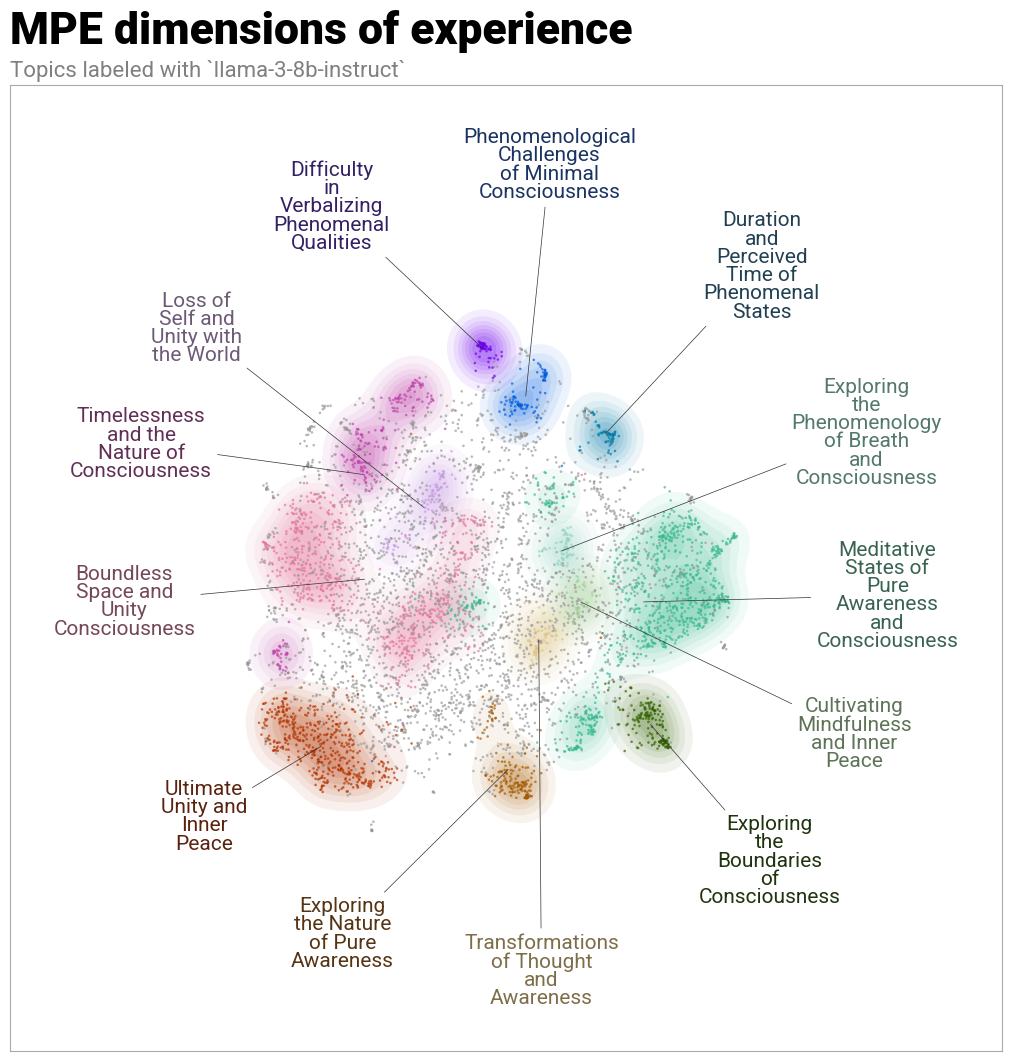

In [28]:
# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]


# Run the visualization
datamapplot.create_plot(
   reduced_embeddings,
   all_labels,
   label_font_size=15,
   title="MPE dimensions of experience",
   sub_title="Topics labeled with `llama-3-8b-instruct`",
   label_wrap_width=10
)

In [29]:
for idx, label in enumerate(llm_labels):
    print(f"Topic {idx}: {label}")

Topic 0: Non dual consciousness and interconnectedness
Topic 1: Meditative States of Pure Awareness and Consciousness
Topic 2: Boundless Space and Unity Consciousness
Topic 3: Ultimate Unity and Inner Peace
Topic 4: Timelessness and the Nature of Consciousness
Topic 5: Exploring the Boundaries of Consciousness
Topic 6: Exploring the Nature of Pure Awareness
Topic 7: Loss of Self and Unity with the World
Topic 8: Phenomenological Challenges of Minimal Consciousness
Topic 9: Exploring the Phenomenology of Breath and Consciousness
Topic 10: Transformations of Thought and Awareness
Topic 11: Difficulty in Verbalizing Phenomenal Qualities
Topic 12: Duration and Perceived Time of Phenomenal States
Topic 13: Cultivating Mindfulness and Inner Peace


### Outlier reduction

In [ ]:
print("reduction of outlier using embeddings technique")
new_topics = topic_model.reduce_outliers(docs, topics, strategy="embeddings",threshold=0.5)



new_all_labels = [llm_labels[topic + topic_model._outliers] if topic != -1 else "Unlabelled" for topic in new_topics] # prepare new labels based on the new topics after outlier reduction

fig_reduced_outliers = topic_model.visualize_documents(docs, 
                                                       topics=new_topics, # Important : utiliser les nouveaux sujets ici
                                                       reduced_embeddings=reduced_embeddings,
                                                       hide_annotations=True, 
                                                       hide_document_hover=False, 
                                                       custom_labels=new_all_labels) # Et les nouvelles étiquettes ici
fig_reduced_outliers.show()


# Update the topics in the model with the new topics after outlier reduction
topic_model.update_topics(docs, topics=new_topics)

topic_info_after_reduction = topic_model.get_topic_info()
display(topic_info_after_reduction)



Réduction des outliers avec la stratégie 'embeddings'...
Affichage du graphique avec les outliers réduits...


2025-07-02 12:39:55,394 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



Mise à jour du modèle et affichage des nouvelles informations sur les sujets...


,Topic,Count,Name,Representation,LLM,Representative_Docs
0,-1,1015,-1_it_the_to_is,"[it, the, to, is, and, in, this, was, of, that]",[Non-dual consciousness and interconnectedness...,"[From the experience of emptiness, there is th..."
1,0,1150,0_meditation_the_in_of,"[meditation, the, in, of, and, during, my, to,...",[Meditative States of Pure Awareness and Consc...,[My first experience of pure awareness was the...
2,1,1230,1_was_and_the_of,"[was, and, the, of, it, my, felt, that, as, in]","[Boundless Space and Unity Consciousness, , , ...","[I had the ""feeling"" that I was the whole worl..."
3,2,707,2_of_and_the_is,"[of, and, the, is, feeling, being, in, it, tha...","[Ultimate Unity and Inner Peace, , , , , , , ,...",[It is a feeling of being one with oneself and...
4,3,304,3_no_there_nothing_was,"[no, there, nothing, was, time, of, the, empti...","[Timelessness and the Nature of Consciousness,...","[I had no sense of time., There was no sense o..."
5,4,234,4_dream_awake_in_the,"[dream, awake, in, the, sleep, and, waking, lu...","[""Exploring the Boundaries of Consciousness"", ...",[I became lucid in a dream and remained lucid ...
6,5,378,5_awareness_of_pure_is,"[awareness, of, pure, is, the, in, not, and, t...","[Exploring the Nature of Pure Awareness, , , ,...","[Pure awareness that there is no awareness., F..."
7,6,189,6_was_am_the_me,"[was, am, the, me, there, no, everything, that...","[Loss of Self and Unity with the World, , , , ...",[may have arisen there was no correlation of t...
8,7,165,7_experience_experiences_this_to,"[experience, experiences, this, to, the, not, ...",[Phenomenological Challenges of Minimal Consci...,[I have not answered some questions or left th...
9,8,120,8_breath_breathing_the_my,"[breath, breathing, the, my, and, body, of, in...",[Exploring the Phenomenology of Breath and Con...,"[Gradually, the attentiveness to the breath be..."


In [31]:
topic_info_after_reduction

,Topic,Count,Name,Representation,LLM,Representative_Docs
0,-1,1015,-1_it_the_to_is,"[it, the, to, is, and, in, this, was, of, that]",[Non-dual consciousness and interconnectedness...,"[From the experience of emptiness, there is th..."
1,0,1150,0_meditation_the_in_of,"[meditation, the, in, of, and, during, my, to,...",[Meditative States of Pure Awareness and Consc...,[My first experience of pure awareness was the...
2,1,1230,1_was_and_the_of,"[was, and, the, of, it, my, felt, that, as, in]","[Boundless Space and Unity Consciousness, , , ...","[I had the ""feeling"" that I was the whole worl..."
3,2,707,2_of_and_the_is,"[of, and, the, is, feeling, being, in, it, tha...","[Ultimate Unity and Inner Peace, , , , , , , ,...",[It is a feeling of being one with oneself and...
4,3,304,3_no_there_nothing_was,"[no, there, nothing, was, time, of, the, empti...","[Timelessness and the Nature of Consciousness,...","[I had no sense of time., There was no sense o..."
5,4,234,4_dream_awake_in_the,"[dream, awake, in, the, sleep, and, waking, lu...","[""Exploring the Boundaries of Consciousness"", ...",[I became lucid in a dream and remained lucid ...
6,5,378,5_awareness_of_pure_is,"[awareness, of, pure, is, the, in, not, and, t...","[Exploring the Nature of Pure Awareness, , , ,...","[Pure awareness that there is no awareness., F..."
7,6,189,6_was_am_the_me,"[was, am, the, me, there, no, everything, that...","[Loss of Self and Unity with the World, , , , ...",[may have arisen there was no correlation of t...
8,7,165,7_experience_experiences_this_to,"[experience, experiences, this, to, the, not, ...",[Phenomenological Challenges of Minimal Consci...,[I have not answered some questions or left th...
9,8,120,8_breath_breathing_the_my,"[breath, breathing, the, my, and, body, of, in...",[Exploring the Phenomenology of Breath and Con...,"[Gradually, the attentiveness to the breath be..."


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `llama-3-8b-instruct` (after outlier reduction)'}>)

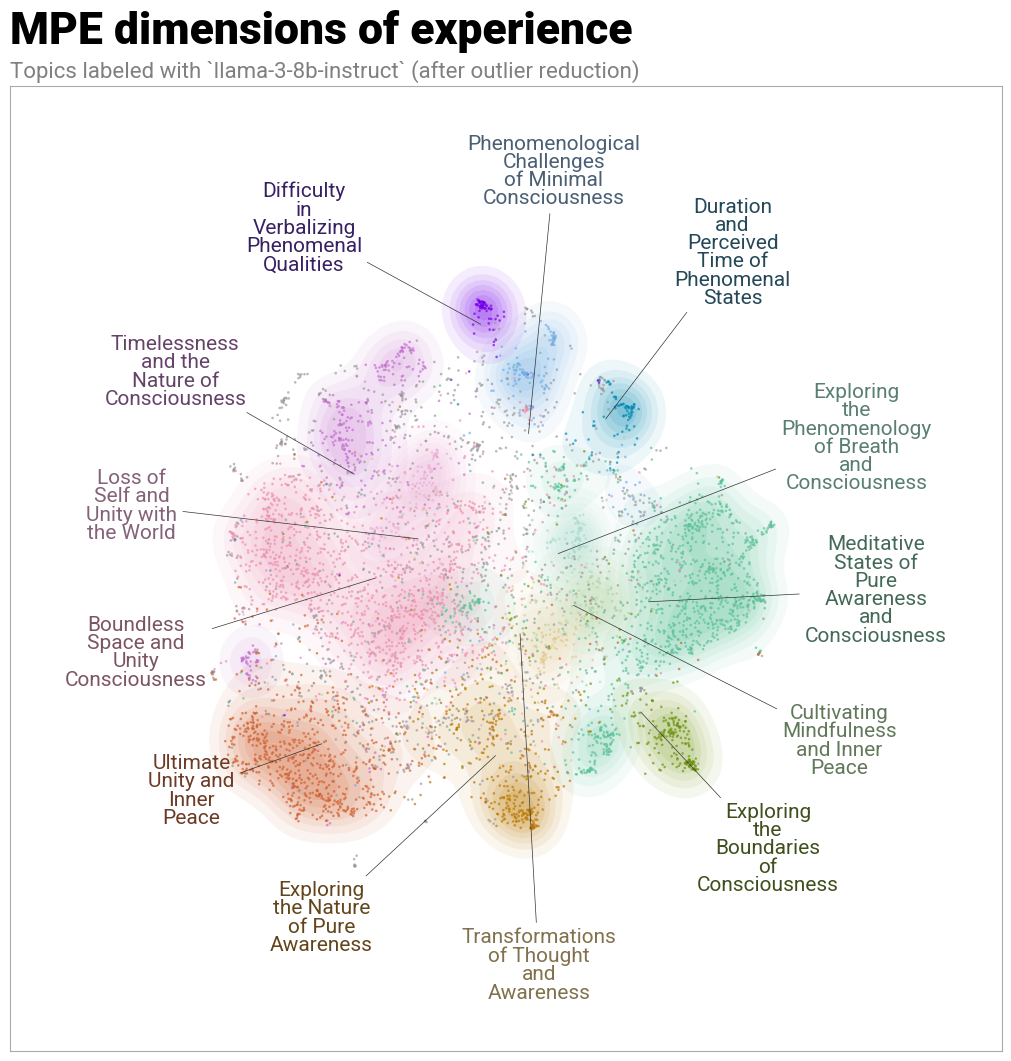

In [34]:
# Visualize the documents with the updated topic assignments in new_topics
datamapplot.create_plot(
    reduced_embeddings,
    [llm_labels[topic + topic_model._outliers] if topic != -1 else "Unlabelled" for topic in new_topics],
    label_font_size=15,
    title="MPE dimensions of experience",
    sub_title="Topics labeled with `llama-3-8b-instruct` (after outlier reduction)",
    label_wrap_width=10
)

In [35]:
for idx, label in enumerate(llm_labels):
    print(f"Topic {idx}: {label}")

Topic 0: Non dual consciousness and interconnectedness
Topic 1: Meditative States of Pure Awareness and Consciousness
Topic 2: Boundless Space and Unity Consciousness
Topic 3: Ultimate Unity and Inner Peace
Topic 4: Timelessness and the Nature of Consciousness
Topic 5: Exploring the Boundaries of Consciousness
Topic 6: Exploring the Nature of Pure Awareness
Topic 7: Loss of Self and Unity with the World
Topic 8: Phenomenological Challenges of Minimal Consciousness
Topic 9: Exploring the Phenomenology of Breath and Consciousness
Topic 10: Transformations of Thought and Awareness
Topic 11: Difficulty in Verbalizing Phenomenal Qualities
Topic 12: Duration and Perceived Time of Phenomenal States
Topic 13: Cultivating Mindfulness and Inner Peace


In [36]:
llm_labels

['Non dual consciousness and interconnectedness',
 'Meditative States of Pure Awareness and Consciousness',
 'Boundless Space and Unity Consciousness',
 'Ultimate Unity and Inner Peace',
 'Timelessness and the Nature of Consciousness',
 'Exploring the Boundaries of Consciousness',
 'Exploring the Nature of Pure Awareness',
 'Loss of Self and Unity with the World',
 'Phenomenological Challenges of Minimal Consciousness',
 'Exploring the Phenomenology of Breath and Consciousness',
 'Transformations of Thought and Awareness',
 'Difficulty in Verbalizing Phenomenal Qualities',
 'Duration and Perceived Time of Phenomenal States',
 'Cultivating Mindfulness and Inner Peace']

In [ ]:

fig_reduced_outliers = topic_model.visualize_documents(docs, 
                                                       topics=new_topics, 
                                                       reduced_embeddings=reduced_embeddings,
                                                       hide_annotations=True, 
                                                       hide_document_hover=False, 
                                                       custom_labels=new_all_labels) 
fig_reduced_outliers.show()


topic_model.update_topics(docs, topics=new_topics)

topic_info_after_reduction = topic_model.get_topic_info()
display(topic_info_after_reduction)

### sanity check of resulting topics: check what's inside each topic

In [ ]:
#topic 1:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 0].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 0]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

My first experience that would fit your description of "consciousness of consciousness" occurred at a very young age.
At 16, I came into contact with Zen.
Initially skeptical, I declared that I had no interest in meditation.
After a year of almost daily meditation, I participated in my first sesshin, later (after studying Japanese studies) I became a monk in a Zen monastery in Japan.
Each meditation means a different experience.
When I then believed that this would kill me, and yet completely surrendered to it ("Let the other monks bury me here tonight!
Therefore, I have mostly understood my Zen practice as not focusing my attention on the inner observer (the lonely spectator in the cinema), but forgetting the seat in the cinema and instead re-identifying myself with the actor on the screen and the ever-unfinished script.
My experience of consciousness occurred during meditation; suddenly I felt as if my body was dissolving and becoming something like energy.
I experienced pure awarene

In [ ]:
#topic 2:

topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 1].index[0]

topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 1]

for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

I felt like a lonely spectator in an empty cinema who suddenly realized that he is not the main actor in the film he is watching.
This experience was surprising insofar as I had almost disassociated myself from my body (the main actor in the film) ("That's not me at all!").
Important for me were experiences in which I felt I was reaching an inner (and also outer, physical) limit.
"), everything became very simple.
My thinking stopped, stood still, and everything disappeared for a short moment from my mind.
I felt elevated to a higher plane, where in peace I could witness emptiness of the mind.
Floating in Cosmos must feel a bit like this.
The beauty became overwhelming, I understood that such beauty was not of this world, could never be seen in this world by anyone.
Not being religious, I was paralyzed and in awe.
I felt on the edge of something.
I attained a state where I felt I could ask any question, or rather face any question, and I would find the answer, within me.
The knot was r

In [ ]:
#topic 3:

topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 2].index[0]

topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 2]

for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

Presence of the here and now.
The state of observing one's own experience from the perspective of pure space.
The unhealthy searching, the torment of control, abruptly ends, and for the first time one realizes what it means to be alive.
It is the knowledge of not being able to harm anything or anyone; the true self is untouchable, timeless, and the essence from which all life springs and returns.
Dissolution of time, space, mind, and the self (individuality).
And connection with everything.
A space without thought, very fluid.
And a very pleasant sensation of gratitude and lightness.
A special state of vastness that permeated everything, me, the outside world, my actions... (what I had to do...) very intense in experience, a feeling of oneness, and a pleasant, healthy state.
Perhaps it can best be described as "simply being" and metaphorically best as "peaceful and weightless."
It is a state of all things falling away.
Like the ultimate escape from discursive thought.
It is clear, awak

In [ ]:
#topic 4:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 3].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 3]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

The insight crystallized, that of course there was no certainty, no first law, or last principle, or final system, from which the world as it is can be described and explained.
It didn't exist.
Then the chronology becomes diffuse.
I may not be able to tell the events in their proper order, or perhaps the order as such did not exist at the time in the place where my mind was.
Where the concepts of things disappeared.
There was only the shine reflected on the wood in the corridor, feeling (I) no longer had a border to the world, and neither did the world.
The emptiness was luminous.
There were no boundaries.
I didn't think about anything.
There was nothing to think about.
There was no separation between the light and the awareness.
I tried not to cling to any thoughts, perceptions, or emotions.
Time seemed to stand still until the next thought.
The experience was one of effortlessness, and without any noticeable sense of desire.
There were no sounds, sights, colors, or objects.
There was

In [ ]:
#topic 5:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 4].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 4]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

One night, before falling asleep, my mind being focused on something completely different, with a massive shock, something happened inside me.
The experience itself happened as I was physically asleep.
I "woke up" realizing that I was meditating in the sleep state.
The light and the awareness became hyper-present and I felt more awake than ever during normal waking consciousness.
It might be worth mentioning that I have had numerous experiences of awareness of the sleep state over the years and that I think these are meditation-related.
and not characterized by hyper-awareness, but rather had a dream-like quality.
One experience was a feeling of a dreamlike state that lasted for several days, where everything was harmonious, in order, easily perceivable, but I felt little to no urge to react to what I was experiencing.
A third state that I remember very well was characterized by incredible clarity; this was in a dream.
I was awake (except in one of the mentioned ones, where I dreamt an

In [ ]:
#topic 6:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 5].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 5]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:40]:
    print(sentences[idx])

Pure awareness, for me, is an all-pervasive state where the boundary between myself and the surrounding reality merges, while both my body and reality remain clear.
However, I also believe that I and perhaps most other people can claim that even in their normal state they are not only conscious, but also conscious of their consciousness.
I cannot render the question more precisely, but I consciously found myself facing the reason for my quest for the ultimate truth.
Pure awareness is the realization of finally having found home after an eternal search.
The main and almost exclusive contents of consciousness were light and awareness.
I may be mixing sensations from different experiences of pure awareness in this report, as it is difficult for me to specifically recall one experience.
Firstly, when recognizing one's natural state, the recognizer dissolves into its ground.
Looking back at who knows this, one realizes the non-dual wisdom.
That cannot be known by the mind.
It was a clear aw

In [ ]:
#topic 7:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 6].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 6]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

Who am I?"
My first experience was that I not only have a body (like a tool), but in a certain way I am this body.
And I still somehow existed, as a witness, as a receiver of grace.
It became clear to me, and it was as if a play was played to me to illustrate this, that my life on earth was just a temporary creation, or a game, that all my encounters with other people, with everything, were arranged for me, as situations, but that myself, and all these encountered, were now lifted away, and it was revealed, that there were but creatures, who had been put there to play a role, as characters in a play, who collapse back into the actors they really are, when the show is over, and go back behind the scene to rest, like puppets.
In this process, I started to disappear, to dissolve as a separate being and to go back into and unite with whom was showing me himself and all.
Steffi Drüge It would be really nice if I were not named, as this type of description is actually personal and does not r

In [ ]:
#topic 8:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 7].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 7]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

These experiences have, however, been mostly negative (including sleep paralysis, sensed evil presences etc.)
Rather than feeling myself as THAT TO WHICH these experiences were given, I felt myself identical with the ACTIVITY of experiencing itself.
This is the source of all experiences.
My answers regarding questionnaire 2 refer to this experience.
This experience is happening now and is not a recollected state.
The experience occurred drug-induced.
I have had several experiences, but the last one was by far the most intense.
I will try to describe it like this: In my normal experience, I – despite better knowledge and also despite this experience – have the feeling that "I" experience something.
Or also: I simply WAS this experience.
So "experiencing" without an "experiencer" felt as real.
I'll start with context as I suspect it's relevant to these kinds of experiences.
I can re-enter this experience at will but without the intensity of this moment.
This experience never again occurr

In [ ]:
#topic 9:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 8].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 8]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

It has to do with a rhythm linked to breathing that becomes a unison between me and every form of life around me.
Through concentration on the breath or body, my perception was 'pulled' away from the perceived towards the perceiving.
After about an hour, I reached the point where my mind became one with the perception of my breath, and all other thoughts and perceptions completely faded into the background.
The resulting feeling of happiness increases the intensity of breath and body perception in bursts.
Gradually, the attentiveness to the breath becomes self-sufficient; a kind of continuity and autonomy of the breath sensation sets in.
Finally, the sensation of the breath becomes weaker, while awareness expands.
Activities around me, noises, changes in lighting conditions materialize as waves in the head and torso area.
Gradually I deepen, the concrete perception of my body as such diminishes, while the perception of my breathing intensifies, until I feel that there is nothing but my

In [ ]:
#topic 10:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 9].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 9]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

One day, the following question arose in my mind: "Who actually asked that?
Who is thinking here?
At that moment, I felt for the first time that I am not my thoughts, but the invisible thinker.
Or if your mind doesn't look for it, it assumes that these things exist anyway, hidden somewhere.
Then I faced the question about the last law and principle, the question about the origin of things and whether there was a primal order, a meaning in the world as it is, the question that had never left me after my small revelation that it was not to be answered by thinking alone.
Furthermore, I felt a hard-to-describe feeling that thoughts were lurking in the back of my mind, of which I was fully aware, but I recognized their transience and insignificance.
There are still occasional bubbles of thought, but they're just part of the fabric of awareness, no longer a sense of an I thinking.
Thoughts still come, but do not disturb this state.
But also many thoughts.
At that moment, the thoughts became 

In [ ]:
#topic 11:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 10].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 10]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

What happened subsequently is beyond words, and any attempt to render it directly or indirectly risks being misleading, banal, and is certainly inadequate, incomplete, contradictory.
It is difficult to describe this state with words because it escapes concepts, descriptions, and the associated evaluations and feelings.
However, the more precisely I try to record it in writing here, the more difficult it becomes.
I hope I have been able to express the essential.
I notice that an alternative is offered here.
It is impossible to fully put it into words but I have tried to give some idea of what it was like below.
I am aware that this can be easily misunderstood.
Nevertheless, I have tried to write them down.
It cannot be described in words.
And as best I tried: the description is poor and wrong.
Nevertheless, here is a pathetic attempt.
I personally can't make anything of this term.
Unfortunately, I can't explain it any better.
It's like trying to explain a taste to someone who has never 

In [ ]:
#topic 12:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 11].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 11]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

5 hours a day before the experience happened.
I usually had the problem of lying awake for about two hours, sometimes longer.
I think it lasted 5-10 minutes, but it's really hard to know.
The state lasts for a while, feels timeless, but ends quite precisely at the usual time, so after about an hour.
It was a timeless state…I have no idea if it lasted 5 minutes or an hour.
This happened for three whole days.
More than 25 minutes makes impatience noticeable.
Previously, this pause was very short; now this emptiness is significantly longer.
As soon as the head switches on again, it's over.
I don't know how long the state lasted.
Sometimes only a few seconds, never longer than 3 to a maximum of 5 minutes.
In fact, I completely recovered during this time.
This lasted for an estimated few minutes.
I can't say how long I actually stood there.
This state lasted for an indefinite period.
It lasted 45 minutes (during lunch, which I hated during the retreat :-)).
Unfortunately, this experience pr

In [ ]:
#topic 13:

# Find the index for topic 8 in topic_info_after_reduction
topic_idx = topic_info_after_reduction[topic_info_after_reduction['Topic'] == 12].index[0]

# Get the indices of sentences assigned to topic 8 in new_topics
topic_sentence_indices = [i for i, t in enumerate(new_topics) if t == 12]

# Print the first 10 sentences of topic 8
for idx in topic_sentence_indices[:30]:
    print(sentences[idx])

Then we relax by letting concentration dissolve into awareness within time.
It becomes increasingly difficult not to fall out of this perception, to take the increasing intensity as an occasion to return to the familiar security of conceptual thinking.
At one point, a slight feeling of fear arises because I don't know what's happening.
However, I also manage to relax this sensation, to let it merge into the process of experiencing.
Out of habit, I set about pushing away the rebellious part.
I remain in this state until it slowly subsides, then return to the walking meditation.
Normally, my impression while sitting is as if I am trying to climb a smooth wall: I try to focus, slip off, notice my distraction, try to focus again, etc.
If it goes badly, of course I simply doze until the bell rings.
But then there are also the rare moments where all this effort (focusing) falls away for some reason, and I am so to speak unintentionally focused.
The expression of this state of mind is gradual

In [38]:
topic_model.set_topic_labels(new_labels)
hierarchy_vis = topic_model.visualize_hierarchy(custom_labels=new_labels, color_threshold=0.5)
hierarchy_vis

(<Figure size 1000x1000 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `llama-3-8b-instruct` (after outlier reduction)'}>)

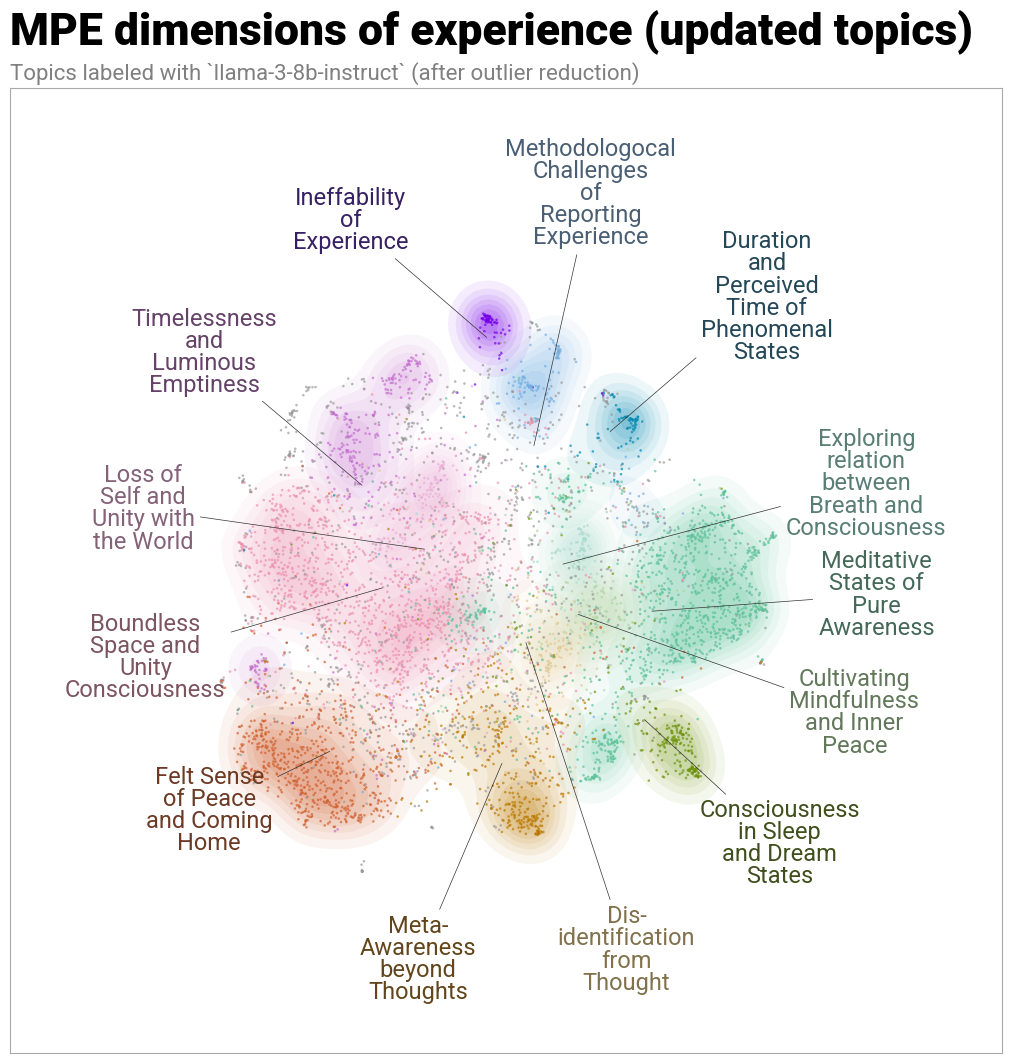

In [39]:
# Visualize the documents with the updated topic assignments in new_topics

datamapplot.create_plot(
    reduced_embeddings,
    [new_labels[topic + topic_model._outliers] if topic != -1 else "Unlabelled" for topic in new_topics],
    label_font_size=17,
    title="MPE dimensions of experience (updated topics)",
    sub_title="Topics labeled with `llama-3-8b-instruct` (after outlier reduction)",
    label_wrap_width=10
)